In [1]:
#!curl -Lso "train_img.gz" https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
#!curl -Lso "train_label.gz" https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
#!curl -Lso "test_img.gz" https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
#!curl -Lso "test_label.gz" https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz

In [2]:
import gzip, os, hashlib, requests
import numpy as np
f = gzip.open("test_img.gz", "r")

image_size_1d = 28

f.read(16)
buf = f.read(image_size_1d * image_size_1d * 10)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(10, image_size_1d, image_size_1d, 1)

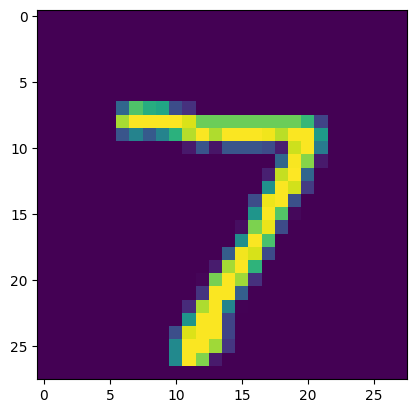

In [32]:
import matplotlib.pyplot as plt

image = np.asarray(data[0]).squeeze()
plt.imshow(image)
plt.show()
data.shape
f.close()

DOG

In [4]:
path = '/home/phfischer/projects/MNIST/data'

def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [5]:
train_img_data = fetch("https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape(-1, 28, 28)
train_lab_data = fetch("https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz")[8:]
test_img_data = fetch("https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1, 28*28)
test_lab_data = fetch("https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [6]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=train_img_data[train_no,:,:],train_img_data[val_no,:,:]
Y_train,Y_val=train_lab_data[train_no],train_lab_data[val_no]

In [7]:
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1=init(28*28,128)
l2=init(128,10)

In [8]:
#Sigmoid funstion
def sigmoid(x):
    return 1/(np.exp(-x)+1)    

#derivative of sigmoid
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [9]:
#Softmax
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [10]:
#forward and backward pass
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    
    x_l1p=x.dot(l1)
    x_sigmoid=sigmoid(x_l1p)
    x_l2p=x_sigmoid.dot(l2)
    out=softmax(x_l2p)
   
 
    error=2*(out-targets)/out.shape[0]*d_softmax(x_l2p)
    update_l2=x_sigmoid.T@error
    
    
    error=((l2).dot(error.T)).T*d_sigmoid(x_l1p)
    update_l1=x.T@error

    return out,update_l1,update_l2 

In [11]:
epochs=10000
lr=3e-3
batch=512

losses,accuracies,val_accuracies=[],[],[]

for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]
 

    out,update_l1,update_l2=forward_backward_pass(x,y)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    loss=((category-y)**2).mean()
    losses.append(loss.item())
    
    l1=l1-lr*update_l1
    l2=l2-lr*update_l2
    
    if(i%20==0):    
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f} | loss: {loss:.3f}')
print(f'For last epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f} | loss: {loss:.3f}')

For 0th epoch: train accuracy: 0.057 | validation accuracy:0.068 | loss: 17.773
For 500th epoch: train accuracy: 0.568 | validation accuracy:0.601 | loss: 7.316
For 1000th epoch: train accuracy: 0.699 | validation accuracy:0.721 | loss: 5.943
For 1500th epoch: train accuracy: 0.773 | validation accuracy:0.760 | loss: 3.908
For 2000th epoch: train accuracy: 0.760 | validation accuracy:0.776 | loss: 5.227
For 2500th epoch: train accuracy: 0.787 | validation accuracy:0.787 | loss: 4.014
For 3000th epoch: train accuracy: 0.805 | validation accuracy:0.797 | loss: 3.477
For 3500th epoch: train accuracy: 0.791 | validation accuracy:0.803 | loss: 3.596
For 4000th epoch: train accuracy: 0.781 | validation accuracy:0.807 | loss: 4.174
For 4500th epoch: train accuracy: 0.824 | validation accuracy:0.811 | loss: 2.822
For 5000th epoch: train accuracy: 0.824 | validation accuracy:0.815 | loss: 3.465
For 5500th epoch: train accuracy: 0.807 | validation accuracy:0.817 | loss: 3.076
For 6000th epoch: t

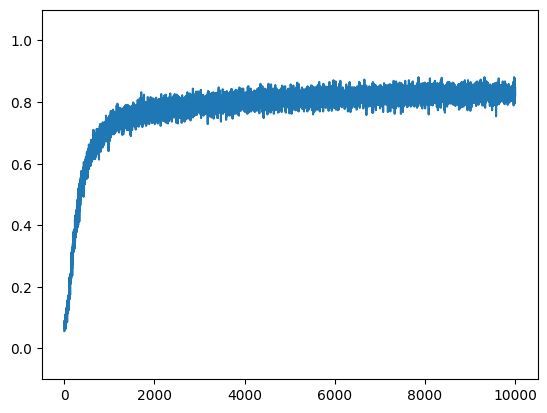

In [12]:
plt.ylim(-0.1, 1.1)
plt.plot(accuracies)

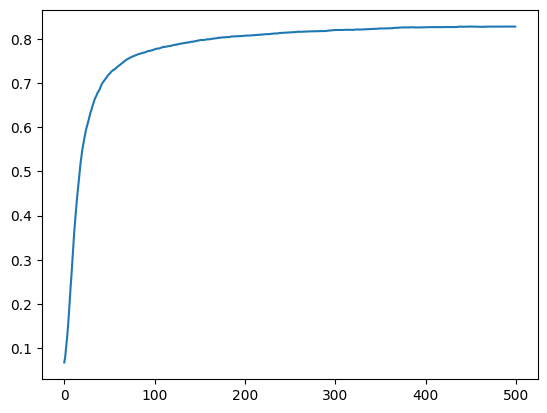

In [13]:
plt.plot(val_accuracies)

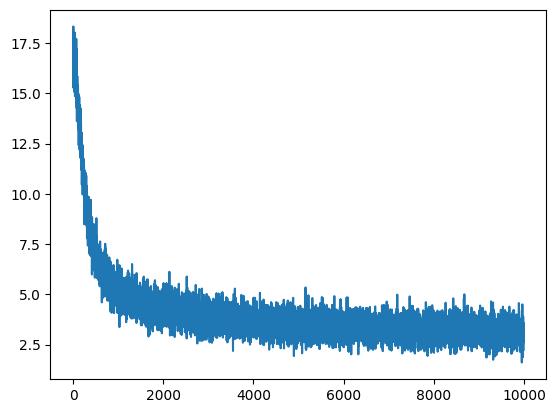

In [14]:
plt.plot(losses)

In [15]:
test_out=np.argmax(softmax(sigmoid(test_img_data.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==test_lab_data).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')
 

Test accuracy = 83.41%


array([7])

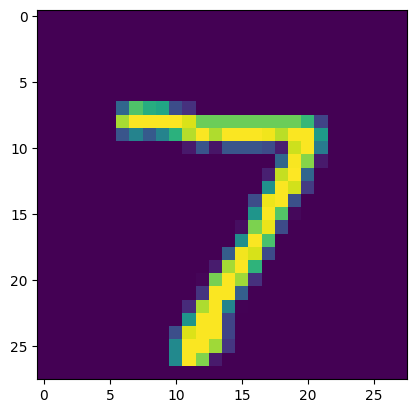

In [33]:
x1 = np.argmax(sigmoid(image.reshape(1,-1).dot(l1)).dot(l2),axis=1)
plt.imshow(image)
x1

array([6])

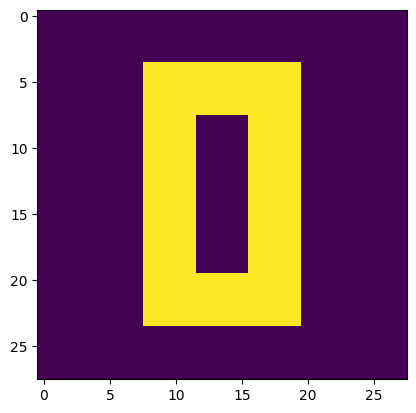

In [16]:
n0 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n0 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n0])
n0=n0.reshape(1,-1)
plt.imshow(n0.reshape(28,28))
y0 = np.argmax(sigmoid(n0.dot(l1)).dot(l2),axis=1)
y0

array([1])

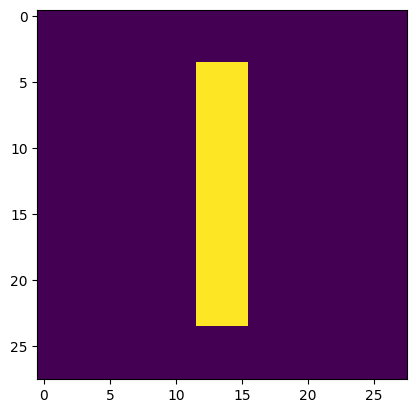

In [17]:
n1 = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

n1 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n1])
n1=n1.reshape(1,-1)
plt.imshow(n1.reshape(28,28))
y1 = np.argmax(sigmoid(n1.dot(l1)).dot(l2),axis=1)
y1

array([6])

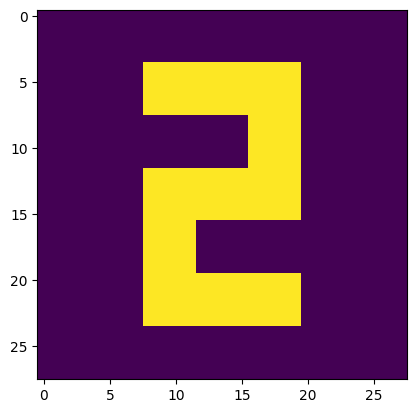

In [18]:
n2 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n2 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n2])
n2=n2.reshape(1,-1)
plt.imshow(n2.reshape(28,28))
y2 = np.argmax(sigmoid(n2.dot(l1)).dot(l2),axis=1)
y2

array([3])

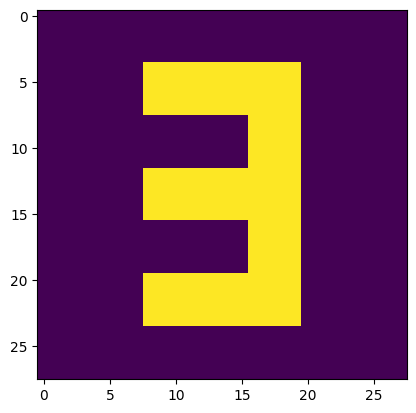

In [19]:
n3 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n3 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n3])
n3=n3.reshape(1,-1)
plt.imshow(n3.reshape(28,28))
y3 = np.argmax(sigmoid(n3.dot(l1)).dot(l2),axis=1)
y3

array([6])

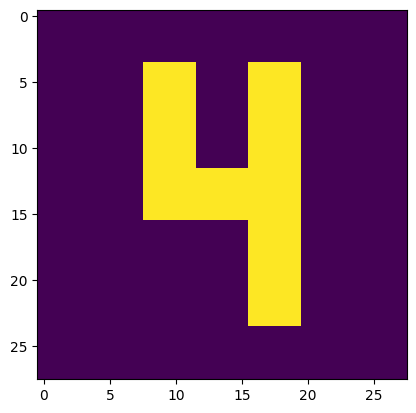

In [20]:
n4 = [[0,0,0,0,0,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

n4 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n4])
n4=n4.reshape(1,-1)
plt.imshow(n4.reshape(28,28))
y4 = np.argmax(sigmoid(n4.dot(l1)).dot(l2),axis=1)
y4

array([6])

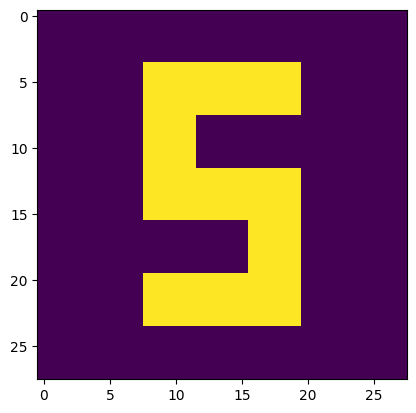

In [21]:
n5 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n5 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n5])
n5=n5.reshape(1,-1)
plt.imshow(n5.reshape(28,28))
y5 = np.argmax(sigmoid(n5.dot(l1)).dot(l2),axis=1)
y5


array([6])

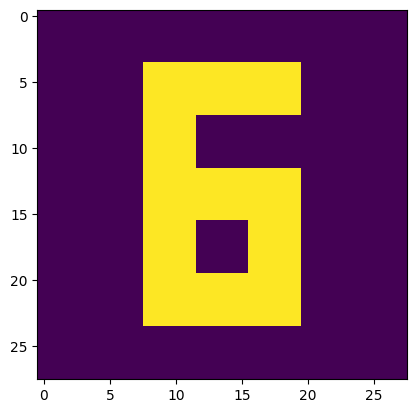

In [22]:
n6 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n6 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n6])
n6=n6.reshape(1,-1)
plt.imshow(n6.reshape(28,28))
y6 = np.argmax(sigmoid(n6.dot(l1)).dot(l2),axis=1)
y6

array([7])

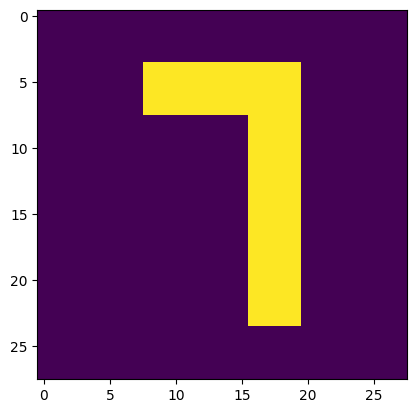

In [23]:
n7 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

n7 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n7])
n7=n7.reshape(1,-1)
plt.imshow(n7.reshape(28,28))
y7 = np.argmax(sigmoid(n7.dot(l1)).dot(l2),axis=1)
y7

array([6])

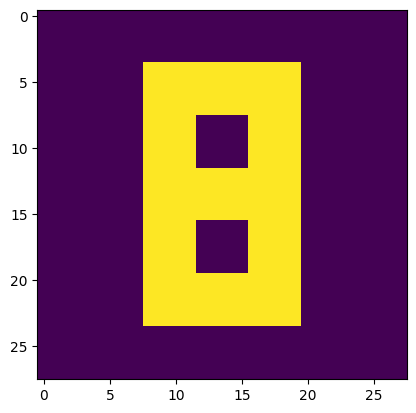

In [24]:
n8 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n8 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n8])
n8=n8.reshape(1,-1)
plt.imshow(n8.reshape(28,28))
y8 = np.argmax(sigmoid(n8.dot(l1)).dot(l2),axis=1)
y8

array([6])

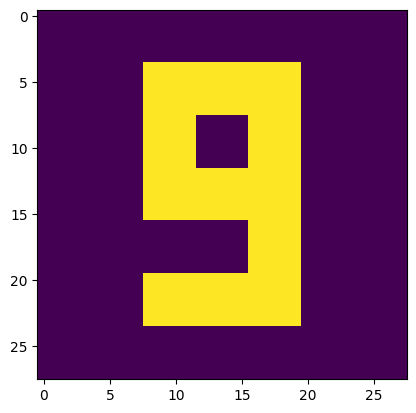

In [25]:
n9 = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,10,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,0,0,0]]

n9 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n9])
n9=n9.reshape(1,-1)
plt.imshow(n9.reshape(28,28))
y9 = np.argmax(sigmoid(n9.dot(l1)).dot(l2),axis=1)
y9